In [29]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
from LowLevelModules.XPScontroller import XPSstage
from LowLevelModules.NIdaqAPD import APDCounter
from LowLevelModules.GeneralFunctions import *
import time
import ipywidgets as widgets
from IPython.display import display
from scipy.optimize import curve_fit
import numpy as np
from sklearn.metrics import r2_score

# stage stuff
ip_address = '169.254.66.147'
portnum = 5001
groupnum = 1
stage_for_scan = XPSstage(ip_address, portnum, groupnum)

..\LowLevelModules\XPScontroller.py:54: ResourceWarning: unclosed <socket.socket fd=692, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('169.254.66.148', 53098), raddr=('169.254.66.147', 5001)>
  XPS.__sockets[socketId] = socket.socket(socket.AF_INET, socket.SOCK_STREAM)


<IPython.core.display.Javascript object>


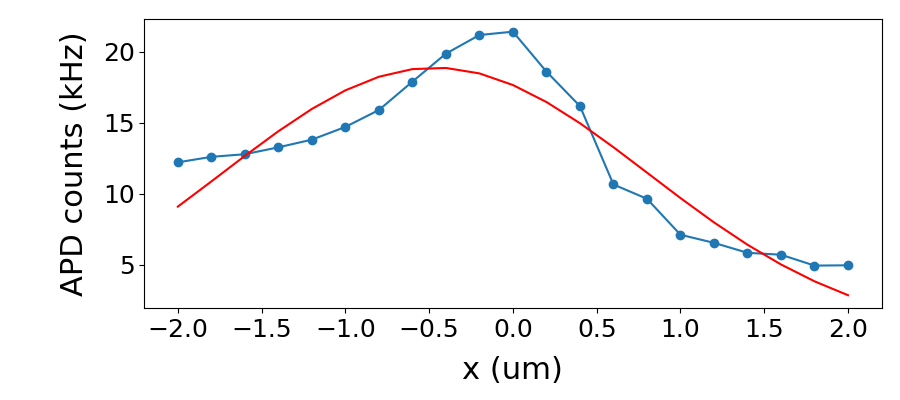

Optimized from fit
FWHM is 2.991372 um
Position before scan:  -3.006025
Position after scan:  -3.00497


In [30]:
"""#######################################   Default parameters   #########################################"""
terminal = "/Dev1/PFI5"   # APD that has the HWP and polarizer in front
scan_extent = 2    #microns
step_size = .2 
collection_time = .2   #seconds
"""#########################################################################################################"""

# move the stage to start scan
steps = int(2 * scan_extent/step_size)
pos_before_scan = stage_for_scan.read_position()
time.sleep(collection_time)
stage_for_scan.move_by(-1* (scan_extent+step_size)/1000)
time.sleep(collection_time)
shifts = np.arange(-scan_extent, scan_extent+step_size, step_size)

lp = LivePlot(1, 1, 9, 4, 'o', 'x (um)', 'APD counts (kHz)')
pos, cts = [], []
for s in shifts:
    try:
        # move stage to new position
        stage_for_scan.move_by(step_size/1000)
        # collect the APD count rate
        APD1 = APDCounter(terminal, task_name='stage scan counts')
        APD1.start()
        time.sleep(collection_time)
        APD_cts = APD1.read() / collection_time / 1000
        APD1.close()
        # get the new data and update the plot
        pos.append(s)
        cts.append(APD_cts)
        lp.plot_live(pos, cts)
    except KeyboardInterrupt:
        # press the stop button to trigger this
        APD1.close()
        stage_for_scan.move_to(pos_before_scan)
        break

# fit data and move the stage
pos, cts = np.array(pos), np.array(cts)
bds = ([.1, -2*scan_extent, 0.0001],[np.inf, 2*scan_extent, 100])
popt, pcov = curve_fit(gaussian_func, pos, cts, bounds=bds)
data_y_fit = gaussian_func(pos, *popt)
plt.plot(pos, data_y_fit, 'r-')
#check validity of the fit
if r2_score(cts, data_y_fit)>.7:
    best_shift = popt[1]
    print("Optimized from fit")
else:
    best_shift = pos[cts.argmax()]
    print("Optimized from max value in scan")
# double check validity
if np.abs(best_shift) > 5:
    best_shift = 0
    print("Actually not! Fit too far off. Staying at initial position")
# move the stage
stage_for_scan.move_to(pos_before_scan + best_shift/1000)
#stage_for_scan.move_to(pos_before_scan)
print("FWHM is %f um" % (2.3548*popt[2]))
print("Position before scan: ", pos_before_scan )
print("Position after scan: ", stage_for_scan.read_position())